In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [2]:
train_path = 'C:/Users/DELL/Downloads/Face recognition/dataset/train/'
valid_path = 'C:/Users/DELL/Downloads/Face recognition/dataset/val/'

In [3]:
# add preprocessing layer to the front of VGG
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False

In [8]:
# useful for getting number of classes
folders = glob('C:/Users/DELL/Downloads/Face recognition/dataset/train/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(resnet.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('C:/Users/DELL/Downloads/Face recognition/dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('C:/Users/DELL/Downloads/Face recognition/dataset/val/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 93 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [27]:
# fit the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
3/3 [==============================] - 20s 7s/step - loss: 0.5948 - accuracy: 0.8065 - val_loss: 1.3943 - val_accuracy: 0.4800
Epoch 2/5
3/3 [==============================] - 19s 7s/step - loss: 0.5554 - accuracy: 0.7849 - val_loss: 1.3780 - val_accuracy: 0.4800
Epoch 3/5
3/3 [==============================] - 19s 7s/step - loss: 0.5829 - accuracy: 0.8065 - val_loss: 1.3839 - val_accuracy: 0.5200
Epoch 4/5
3/3 [==============================] - 20s 7s/step - loss: 0.5860 - accuracy: 0.8387 - val_loss: 1.2659 - val_accuracy: 0.4800
Epoch 5/5
3/3 [==============================] - 18s 6s/step - loss: 0.5341 - accuracy: 0.7957 - val_loss: 1.2789 - val_accuracy: 0.5200


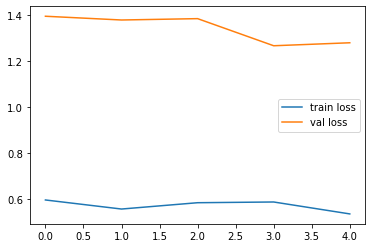

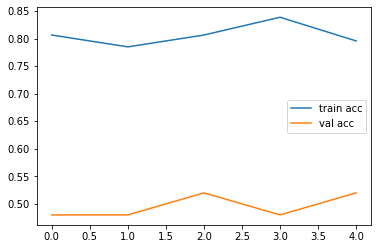

<Figure size 432x288 with 0 Axes>

In [28]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [24]:
import tensorflow as tf

from keras.models import load_model

model.save('C:/Users/DELL/Downloads/Face recognition/ResNet50.h5')

classifier = load_model('ResNet50.h5')

In [25]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

monkey_breeds_dict = {"[0]": "ben_afflek", 
                      "[1]": "elton_john",
                      "[2]": "jerry_seinfeld",
                      "[3]": "madonna",
                      "[4]": "mindy_kaling",
                      
                     }

monkey_breeds_dict_n = {"ben_afflek": "ben_afflek", 
                      "elton_john": "elton_john",
                     "jerry_seinfeld" : "jerry_seinfeld",
                        "madonna":"madonna",
                        "mindy_kaling" : "mindy_kaling",
                      }

def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,5):
    input_im = getRandomImage("dataset/val/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - madonna
Class - jerry_seinfeld
Class - elton_john
Class - ben_afflek
Class - madonna


In [ ]:

from PIL import Image 
import base64
from io import BytesIO
import json
import random
import cv2
import numpy as np
# Loading the cascades
face_cascade = cv2.CascadeClassifier('C:/Users/DELL/Downloads/Face recognition/haarcascade_frontalface_default.xml')

def face_extractor(img):
    # Function detects faces and returns the cropped face
    # If no face detected, it returns the input image
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    if faces is ():
        return None
    
    # Crop all faces found
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face = img[y:y+h, x:x+w]

    return cropped_face

# Doing some Face Recognition with the webcam
video_capture = cv2.VideoCapture(0 + cv2.CAP_DSHOW)
while True:
    _, frame = video_capture.read()
    
    face=face_extractor(frame)
    if type(face) is np.ndarray:
        face = cv2.resize(face, (224, 224))
        im = Image.fromarray(face, 'RGB')
        img_array = np.array(im)            
        img_array = np.expand_dims(img_array, axis=0)
        pred = classifier.predict(img_array)
        print(pred)
                     
        name="None matching"
        
        if(pred[0][0]>0.5):
            name='ben_afflek'
        if(pred[0][1]>0.5):
            name='elton_john'
        if(pred[0][2]>0.5):
            name='jerry_seinfeld'
        if(pred[0][3]>0.5):
            name='madonna'
        if(pred[0][4]>0.5):
            name='mindy_kaling'
        
        cv2.putText(frame,name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    else:
        cv2.putText(frame,"There is no face in the frame", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2)
    #cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()